# Introdution

# Imports

In [1]:
import sys
!{sys.executable} -m pip install tsai


[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: D:\PYTHON_PROJECTS\credit_scoring_project\venv\Scripts\python.exe -m pip install --upgrade pip


In [15]:
# Standard Python & Data Manipulation
import re
import pandas as pd
import numpy as np
import joblib

# Data Science & Scikit-learn
from scipy.signal import find_peaks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Deep Learning (PyTorch, FastAI, TSAI)
import torch
from fastai.callback.core import Callback
from fastai.learner import Learner
from tsai.all import * 
from pytorch_lightning.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'pytorch_lightning'

# First look to data

In [3]:
df = pd.read_csv('data/BTCUSDT-1h.csv',)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.head()

,timestamp,open,high,low,close,volume,num_trades,taker_base_vol
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,171,35.160503
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,102,21.448071
2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,36,4.802861
3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,25,2.602292
4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,28,0.814655


In [4]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp,55921,2020-10-29 04:19:33.906045952,2017-08-17 04:00:00,2019-03-25 18:00:00,2020-10-29 16:00:00,2022-06-04 23:00:00,2024-01-08 12:00:00,NaN
open,55921.0,20982.225801,2870.9,7943.34,15780.28,30567.58,68635.12,15937.649636
high,55921.0,21089.621259,2950.0,7987.0,15920.33,30688.75,69000.0,16020.878161
low,55921.0,20868.543351,2817.0,7901.33,15601.85,30438.26,68451.19,15849.885593
close,55921.0,20982.933097,2919.0,7944.35,15781.29,30567.93,68633.69,15937.802666
volume,55921.0,3055.287069,0.0,960.62656,1680.38554,3280.75121,137207.1886,4335.542116
num_trades,55921.0,60025.923124,0.0,11318.0,28402.0,63945.0,1442097.0,92338.481361
taker_base_vol,55921.0,1519.242397,0.0,483.91991,839.12732,1630.265005,68611.45039,2158.066666


In [5]:
def extended_describe(df):
    df_num = df.select_dtypes(include=np.number)
    desc = df_num.describe().T
    desc["median"] = df_num.median()
    desc["~zeros_count"] = df_num.apply(lambda col: col[(col >= 0) & (col < 0.05)].count())
    desc["~zeros_percent"] = df_num.apply(lambda col: col[(col >= 0) & (col < 0.05)].count() / col.count() * 100)
    desc["mode"] = df_num.apply(lambda col: col.mode().iloc[0] if not col.mode().empty else np.nan)
    desc.drop(columns=["25%", "50%", "75%"], inplace=True)
    return desc

extended_describe(df.drop(columns=['timestamp']))

,count,mean,std,min,max,median,~zeros_count,~zeros_percent,mode
open,55921.0,20982.225801,15937.649636,2870.9,6.863512e+04,15780.28000,0,0.000000,4280.0
high,55921.0,21089.621259,16020.878161,2950.0,6.900000e+04,15920.33000,0,0.000000,6600.0
low,55921.0,20868.543351,15849.885593,2817.0,6.845119e+04,15601.85000,0,0.000000,8050.0
close,55921.0,20982.933097,15937.802666,2919.0,6.863369e+04,15781.29000,0,0.000000,6700.0
volume,55921.0,3055.287069,4335.542116,0.0,1.372072e+05,1680.38554,4,0.007153,0.0
num_trades,55921.0,60025.923124,92338.481361,0.0,1.442097e+06,28402.00000,4,0.007153,262.0
taker_base_vol,55921.0,1519.242397,2158.066666,0.0,6.861145e+04,839.12732,7,0.012518,0.0


# EDA

## Missing values

In [6]:
df.isna().any()

timestamp         False
open              False
high              False
low               False
close             False
volume            False
num_trades        False
taker_base_vol    False
dtype: bool

# Data labeling and features engineering

## Calculating technical analysis indicators and label decisions

In [7]:
def calculate_indicators(df):
    df = df.copy()

    # Prices and shadows
    df['close_open'] = df['close'] / (df['open'] + 1e-10)
    df['high_low_range'] = df['high'] - df['low']
    df['candle_body'] = df['close'] - df['open']
    df['upper_shadow'] = df['high'] - df[['close', 'open']].max(axis=1)
    df['lower_shadow'] = df[['close', 'open']].min(axis=1) - df['low']

    # SMA and MACD
    df['sma10'] = df['close'].rolling(window=10).mean()
    df['sma50'] = df['close'].rolling(window=50).mean()
    df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema12'] - df['ema12'].ewm(span=26, adjust=False).mean()
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # RSI
    delta = df['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain, index=df.index).rolling(14).mean()
    avg_loss = pd.Series(loss, index=df.index).rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['rsi14'] = 100 - (100 / (1 + rs))

    # ROC
    df['roc9'] = 100 * (df['close'] - df['close'].shift(9)) / (df['close'].shift(9) + 1e-10)

    # ATR и Bollinger Bands
    df['tr'] = pd.concat([
        df['high'] - df['low'],
        np.abs(df['high'] - df['close'].shift()),
        np.abs(df['low'] - df['close'].shift())
    ], axis=1).max(axis=1)
    rolling_std_20 = df['close'].rolling(window=20).std()
    df['upper_bb'] = df['sma10'] + 2 * rolling_std_20
    df['bb_width'] = 4 * rolling_std_20
    df['atr14'] = df['tr'].rolling(window=14).mean()

    # Stochastic
    low14 = df['low'].rolling(window=14).min()
    high14 = df['high'].rolling(window=14).max()
    df['stoch_k'] = 100 * (df['close'] - low14) / (high14 - low14 + 1e-10)
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()

    # CCI
    tp = (df['high'] + df['low'] + df['close']) / 3
    ma_tp = tp.rolling(window=20).mean()
    mad = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['cci'] = (tp - ma_tp) / (0.015 * mad + 1e-10)

    # ADX
    up_move = df['high'].diff()
    down_move = -df['low'].diff()
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
    atr14_safe = df['tr'].rolling(window=14).mean() + 1e-10
    plus_di = 100 * pd.Series(plus_dm).rolling(window=14).mean() / atr14_safe
    minus_di = 100 * pd.Series(minus_dm).rolling(window=14).mean() / atr14_safe
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di + 1e-10)
    df['adx'] = dx.rolling(window=14).mean()

    # VWAP
    df['vwap'] = (df['close'] * df['volume']).cumsum() / (df['volume'].cumsum() + 1e-10)

    # Lags features
    df['close_diff_1'] = df['close'] - df['close'].shift(1)
    df['volume_diff_1'] = df['volume'] - df['volume'].shift(1)
    df['volume_pct_change_1'] = df['volume'].pct_change(1)

    # binary features
    df['ema12_cross_ema26_up'] = ((df['ema12'] > df['ema26']) & (df['ema12'].shift(1) <= df['ema26'].shift(1))).astype(int)
    df['ema12_cross_ema26_down'] = ((df['ema12'] < df['ema26']) & (df['ema12'].shift(1) >= df['ema26'].shift(1))).astype(int)
    df['close_cross_sma50_up'] = ((df['close'] > df['sma50']) & (df['close'].shift(1) <= df['sma50'].shift(1))).astype(int)
    df['close_cross_sma50_down'] = ((df['close'] < df['sma50']) & (df['close'].shift(1) >= df['sma50'].shift(1))).astype(int)
    df['macd_cross_signal_up'] = ((df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))).astype(int)
    df['macd_cross_signal_down'] = ((df['macd'] < df['macd_signal']) & (df['macd'].shift(1) >= df['macd_signal'].shift(1))).astype(int)
    df['rsi_overbought'] = (df['rsi14'] > 70).astype(int)
    df['rsi_oversold'] = (df['rsi14'] < 30).astype(int)
    df['close_cross_upper_bb'] = (df['close'] > df['upper_bb']).astype(int)
    df['close_cross_lower_bb'] = (df['close'] < (df['upper_bb'] - df['bb_width'])).astype(int)
    df['strong_trend'] = (df['adx'] > 25).astype(int)

    df = df.round(3)
    return df

def label_decisions(
    df, 
    atr_multiplier_TP=2.5, 
    atr_multiplier_SL=1.25, 
    lookahead=3, 
    volume_threshold=0.4, 
    atr_threshold=0.002,
    volatility_entry_threshold=0.005,
    in_trade=False
):
    df = df.copy()
    df['decision'] = 'HOLD'
    avg_volume = df['volume'].rolling(50).mean()

    for i in range(len(df) - lookahead):
        entry_price = df['close'].iloc[i]
        atr = df['atr14'].iloc[i]
        volume = df['volume'].iloc[i]

        if (
            pd.isna(atr) or 
            atr / entry_price < atr_threshold or 
            volume < avg_volume.iloc[i] * volume_threshold or
            atr / entry_price < volatility_entry_threshold
        ):
            continue

        tp_buy = entry_price + atr * atr_multiplier_TP
        sl_buy = entry_price - atr * atr_multiplier_SL
        for j in range(1, lookahead + 1):
            high = df['high'].iloc[i + j]
            low = df['low'].iloc[i + j]
            if high >= tp_buy and in_trade == False:
                df.at[i, 'decision'] = 'BUY'
                in_trade = True
                break
            if low <= sl_buy:
                break

        if df.at[i, 'decision'] == 'BUY':
            continue

        tp_sell = entry_price - atr * atr_multiplier_TP
        sl_sell = entry_price + atr * atr_multiplier_SL
        for j in range(1, lookahead + 1):
            high = df['high'].iloc[i + j]
            low = df['low'].iloc[i + j]
            if low <= tp_sell and in_trade == False:
                df.at[i, 'decision'] = 'SELL'
                in_trade = True
                break
            if high >= sl_sell:
                break

    df['binary_decision'] = df['decision'].apply(lambda x: 'TRADE' if x in ['BUY', 'SELL'] else 'HOLD')
    return df

In [8]:
df = calculate_indicators(df)
df = label_decisions(df)
df.isna().sum()

timestamp                  0
open                       0
high                       0
low                        0
close                      0
volume                     0
num_trades                 0
taker_base_vol             0
close_open                 0
high_low_range             0
candle_body                0
upper_shadow               0
lower_shadow               0
sma10                      9
sma50                     49
ema12                      0
ema26                      0
macd                       0
macd_signal                0
macd_hist                  0
rsi14                     13
roc9                       9
tr                         0
upper_bb                  19
bb_width                  19
atr14                     13
stoch_k                   13
stoch_d                   15
cci                       19
adx                       26
vwap                       0
close_diff_1               1
volume_diff_1              1
volume_pct_change_1        1
ema12_cross_em

## Features correlation analysis

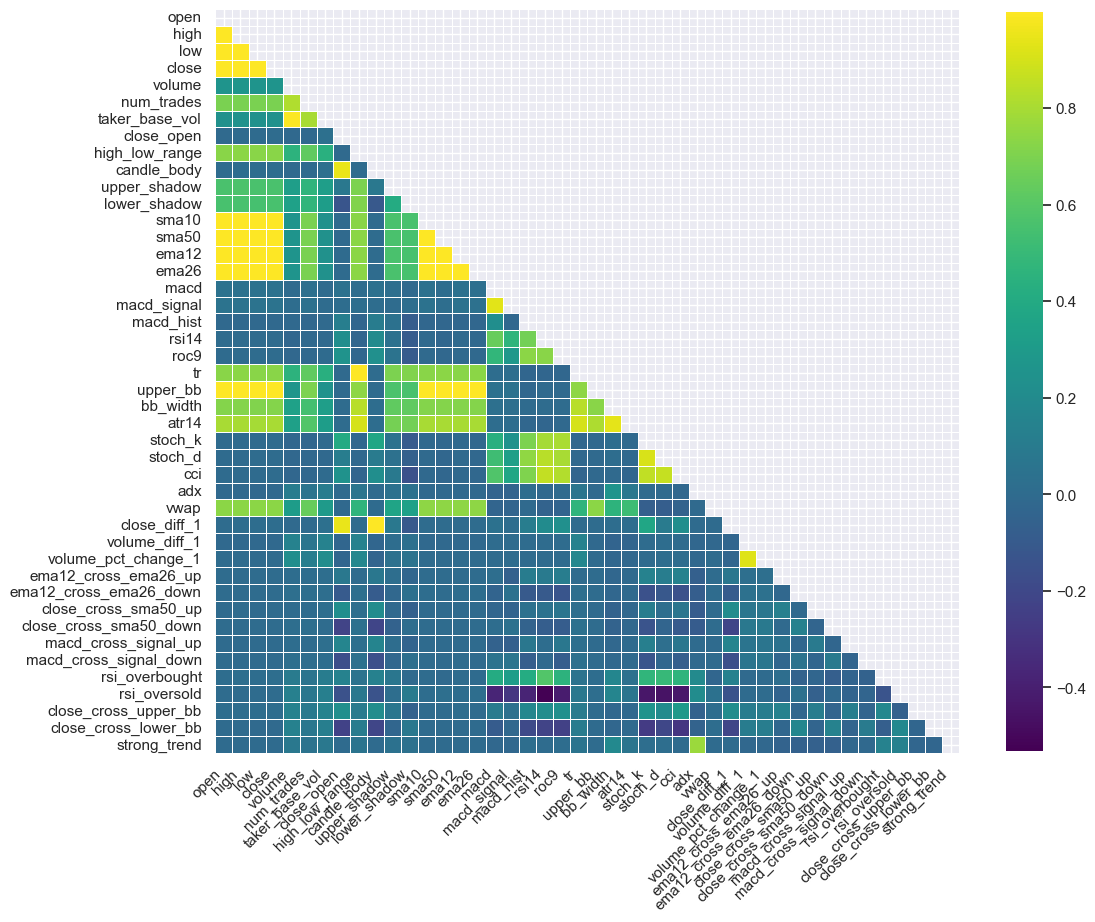

In [9]:
sns.set(font_scale=1.1)
corr_train = df.drop(columns=['decision','binary_decision', 'timestamp']).corr(method="spearman")
mask = np.triu(np.ones_like(corr_train, dtype=bool))

sns.set(font_scale=1.0)
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_train,
    cmap='viridis',
    square=True,
    mask=mask,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

## Corr analysis text interpritation

In [10]:
corr_matrix = df.drop(columns=['decision','binary_decision']).corr(method='spearman')

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

strong_corr = upper_tri.stack().reset_index()
strong_corr.columns = ['feature_1', 'feature_2', 'spearman_corr']
strong_corr = strong_corr[strong_corr['spearman_corr'].abs() > 0.7]

strong_corr = strong_corr.reindex(strong_corr['spearman_corr'].abs().sort_values(ascending=False).index)
strong_corr = strong_corr.sort_values(by = 'spearman_corr', ascending = True)
strong_corr.head(50)

,feature_1,feature_2,spearman_corr
673,macd_hist,cci,0.703540
471,lower_shadow,tr,0.710624
362,high_low_range,lower_shadow,0.710827
149,low,bb_width,0.711772
189,close,bb_width,0.714221
66,open,bb_width,0.714241
504,sma10,bb_width,0.714410
563,ema12,bb_width,0.714494
591,ema26,bb_width,0.714844
534,sma50,bb_width,0.715219


# Data manipulations

In [11]:
def prepare_training_data(df, target_columns=['decision', 'binary_decision'], corr_th=0.75, numeric_candidates=None,
                          binary_name_regex=r'cross|rsi|strong|overbought|oversold'):
    df = df.copy()
    # Default numeric features
    if numeric_candidates is None:
        numeric_candidates = ['macd_hist', 'rsi14', 'atr14', 'tr', 'roc9', 'volume_pct_change_1', 'vwap']
    exclude_always = set(['timestamp', 'sma10', 'hl_mean', 'decision', 'binary_decision', 'atr14', 'volume'])
    exclude_always = exclude_always.union(set(target_columns))

    #Binary features
    binary_cols = []
    for col in df.columns:
        if col in exclude_always:
            continue
        ser = df[col].dropna().unique()
        # if only 0 or 1
        if set(np.unique(ser)).issubset({0, 1}):
            binary_cols.append(col)
            continue
        # check feature name by regex
        if re.search(binary_name_regex, col, flags=re.IGNORECASE):
            vals = df[col].dropna().unique()
            if set(np.unique(vals)).issubset({0,1}):
                binary_cols.append(col)

    binary_cols = sorted(set(binary_cols))
    numeric_candidates = [c for c in numeric_candidates if c in df.columns and c not in exclude_always]

    candidates = binary_cols + numeric_candidates
    candidates = [c for c in candidates if c in df.columns]

    if not candidates:
        raise ValueError("No candidates")
    def select_numeric_min_corr(data, nums, th=corr_th):
        if not nums:
            return []
        sub = data[nums].corr(method='spearman').abs()
        keep = set(nums)
        while True:
            sub_corr = sub.loc[sorted(keep), sorted(keep)]
            mask = np.triu(np.ones_like(sub_corr, dtype=bool), k=1)
            if not mask.any():
                break
            max_val = sub_corr.where(mask).max().max()
            if pd.isna(max_val) or max_val <= th:
                break
            idx = np.where((sub_corr.values == max_val))
            i, j = idx[0][0], idx[1][0]
            col_i = sub_corr.index[i]
            col_j = sub_corr.columns[j]
            mean_i = sub_corr[col_i].mean()
            mean_j = sub_corr[col_j].mean()
            drop_col = col_i if mean_i >= mean_j else col_j
            keep.remove(drop_col)
        return [c for c in nums if c in keep]

    # only numeric with minimum corr
    selected_numerics = select_numeric_min_corr(df, numeric_candidates, th=corr_th)

    # full feature list
    feature_cols = binary_cols + selected_numerics

    X = df[feature_cols].copy()
    y = df[target_columns].copy()

    print("Selected features count:", len(feature_cols))
    print("Selected features:", feature_cols)
    print("Numeric candidates considered:", numeric_candidates)
    print("Selected numeric features:", selected_numerics)
    print("Rows after dropna:", len(df))
    print("Any nan in X:", np.isnan(X.values).sum())

    return X, y
    
X, y = prepare_training_data(df)
df_for_training = pd.concat([X, y], axis=1)

Selected features count: 17
Selected features: ['close_cross_lower_bb', 'close_cross_sma50_down', 'close_cross_sma50_up', 'close_cross_upper_bb', 'ema12_cross_ema26_down', 'ema12_cross_ema26_up', 'macd_cross_signal_down', 'macd_cross_signal_up', 'rsi_overbought', 'rsi_oversold', 'strong_trend', 'macd_hist', 'rsi14', 'tr', 'roc9', 'volume_pct_change_1', 'vwap']
Numeric candidates considered: ['macd_hist', 'rsi14', 'tr', 'roc9', 'volume_pct_change_1', 'vwap']
Selected numeric features: ['macd_hist', 'rsi14', 'tr', 'roc9', 'volume_pct_change_1', 'vwap']
Rows after dropna: 55921
Any nan in X: 23


In [12]:
df_for_training.head()

,close_cross_lower_bb,close_cross_sma50_down,close_cross_sma50_up,close_cross_upper_bb,ema12_cross_ema26_down,ema12_cross_ema26_up,macd_cross_signal_down,macd_cross_signal_up,rsi_overbought,rsi_oversold,strong_trend,macd_hist,rsi14,tr,roc9,volume_pct_change_1,vwap,decision,binary_decision
0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,52.30,NaN,NaN,4308.830,HOLD,HOLD
1,0,0,0,0,0,1,0,1,0,0,0,0.740,NaN,37.32,NaN,-0.508,4310.971,HOLD,HOLD
2,0,0,0,0,0,0,0,0,0,0,0,2.192,NaN,36.08,NaN,-0.689,4312.217,HOLD,HOLD
3,0,0,0,0,0,0,0,0,0,0,0,5.902,NaN,62.58,NaN,-0.385,4314.262,HOLD,HOLD
4,0,0,0,0,0,0,0,0,0,0,0,9.118,NaN,44.53,NaN,-0.781,4314.805,HOLD,HOLD


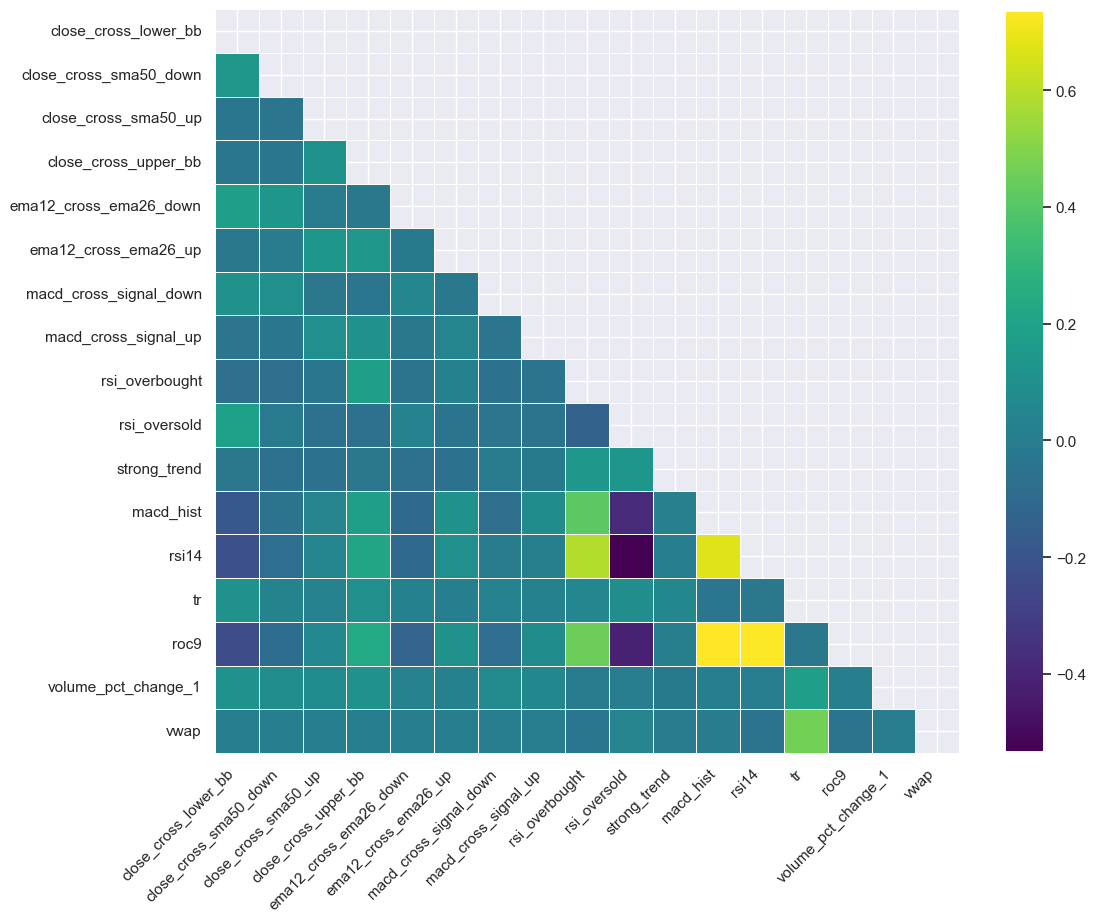

In [13]:
sns.set(font_scale=1.1)
corr_train = df_for_training.drop(columns=['decision','binary_decision']).corr(method="spearman")
mask = np.triu(np.ones_like(corr_train, dtype=bool))

sns.set(font_scale=1.0)
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_train,
    cmap='viridis',
    square=True,
    mask=mask,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Modeling

In [14]:


# --- 0. CONFIGURATION AND INITIAL SETUP ---
# Fix the random seed for reproducibility—never forget this!
seed = 42
set_seed(seed, reproducible=True)

# Data assumed to be loaded and named 'df'
df = df_for_training.iloc[:30000].copy()
seq_len = 256
# Clean up the feature list, excluding decision columns
features = [col for col in df.columns if col not in ['decision', 'binary_decision', 'binary_decision_enc', 'decision_enc']] 

# Standard function to visualize the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# --- 1. DATA PREP HELPER FUNCTIONS ---

def prepare_data_stage1(df, features, seq_len):
    """Encodes binary_decision (HOLD/TRADE) and creates sequential X/y data."""
    le = LabelEncoder()
    df['binary_decision_enc'] = le.fit_transform(df['binary_decision'])
    X, y = [], []
    # Loop over the dataframe to create sliding windows
    for i in range(len(df) - seq_len):
        X.append(df.iloc[i:i+seq_len][features].values.astype(np.float32))
        y.append(df.iloc[i+seq_len]['binary_decision_enc'])
    return np.stack(X), np.array(y), le

def prepare_data_stage2(df, features, seq_len):
    """Filters data for 'TRADE' instances only, encodes decisions (BUY/SELL), and creates sequences."""
    le = LabelEncoder()
    # Only need rows where the first stage decided to TRADE
    df_trade = df[df['binary_decision'] == 'TRADE'].copy() 
    df_trade['decision_enc'] = le.fit_transform(df_trade['decision'])
    
    X, y = [], []
    # Collect sequences only where the next step is a TRADE
    for i in range(len(df) - seq_len):
        if df.iloc[i+seq_len]['binary_decision'] != 'TRADE':
            continue
        X.append(df.iloc[i:i+seq_len][features].values.astype(np.float32))
        y.append(df.iloc[i+seq_len]['decision_enc'])

    return np.stack(X), np.array(y), le

# --- 2. CUSTOM CALLBACK FOR THRESHOLD OPTIMIZATION ---
# This is crucial for unbalanced binary classification when using a custom loss weight.
class ThresholdOptimizer(Callback):
    order = 65 # Run after recording metrics
    def __init__(self, target_class_name='TRADE'):
        self.target_class_name = target_class_name
        self.best_threshold = 0.5

    def after_fit(self):
        # Grab predictions on the validation set (ds_idx=1)
        preds, targets = self.learn.get_preds(ds_idx=1) 
        probs = preds[:, 1].numpy() # Probabilities for the positive class (TRADE)
        targets_np = targets.numpy()
        
        # Grid search for the best threshold
        thresholds = np.linspace(0.1, 0.9, 81)
        best_f1 = -1
        best_t = 0.5
        
        # Optimize for the F1-score of the positive class ('TRADE')
        for t in thresholds:
            y_pred = (probs > t).astype(int)
            # Use F1-score as the balance metric
            report = classification_report(targets_np, y_pred, output_dict=True, zero_division=0, target_names=self.learn.dls.vocab)
            f1 = report[self.target_class_name]['f1-score'] 
            if f1 > best_f1:
                best_f1 = f1
                best_t = t

        self.best_threshold = best_t
        print(f"Optimized Threshold ({self.target_class_name} F1): {self.best_threshold:.4f} (F1: {best_f1:.4f})")


# --- 3. STAGE 1: TRADE vs HOLD ---
X1, y1, le_stage1 = prepare_data_stage1(df, features, seq_len)
# Using custom weights to mitigate class imbalance
weights_tensor1 = torch.tensor([1.2857, 4.5], dtype=torch.float32) 
loss_func1 = torch.nn.CrossEntropyLoss(weight=weights_tensor1)
tscv1 = TimeSeriesSplit(n_splits=5)
all_preds1, all_targets1 = [], []
threshold_optimizer = ThresholdOptimizer(target_class_name=le_stage1.classes_[1]) # Set target class name

print("\n===== STAGE 1: TRADE vs HOLD (Weighted & Threshold Optimized) =====")
for fold, (train_idx, valid_idx) in enumerate(tscv1.split(X1)):
    print(f"\n🔁 Fold {fold + 1}:")

    #TSStandardize to normalize features (calculated only on the training set)
    tfms = [TSStandardize(), TSClassification()] 
    dsets = TSDatasets(X1, y1, tfms=tfms, splits=(train_idx, valid_idx))
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64)

    model = TransformerModel(c_in=dls.vars, c_out=dls.c)
    # Add EarlyStopping (patience=10) and CSVLogger for better management
    learn = Learner(dls, model, metrics=accuracy, loss_func=loss_func1, 
                     cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10), CSVLogger()]) 
    # Use max 200 epochs, but EarlyStopping will likely cut this short
    learn.fit_one_cycle(200, 1e-3) 

    # Optimize and apply the threshold
    threshold_optimizer.learn = learn
    threshold_optimizer.after_fit()
    optimized_threshold = threshold_optimizer.best_threshold
    
    # Get final predictions using the optimized threshold
    preds, targets = learn.get_preds(ds_idx=1)
    probs = preds[:, 1].numpy()
    y_pred = (probs > optimized_threshold).astype(int)
    y_true = targets.numpy()

    all_preds1.extend(y_pred)
    all_targets1.extend(y_true)

print("\n📊 AGGREGATE Report for Stage 1:")
print(f"Using latest optimized threshold: {optimized_threshold:.4f}")
print(classification_report(all_targets1, all_preds1, target_names=le_stage1.classes_))
plot_confusion_matrix(all_targets1, all_preds1, le_stage1.classes_, 'Confusion Matrix All Folds (Stage 1)')

# FINAL TRAINING STAGE 1
# Train the final model on 80% of the data without an internal validation set
X_final_s1, y_final_s1 = X1[:int(len(y1) * 0.8)], y1[:int(len(y1) * 0.8)]
splits1 = (list(range(len(X_final_s1))), []) 
tfms = [TSStandardize(), TSClassification()]
dsets1_final = TSDatasets(X1, y1, tfms=tfms, splits=splits1) 
dls1_final = TSDataLoaders.from_dsets(dsets1_final.train, bs=64)

model1_final = TransformerModel(c_in=dls1_final.vars, c_out=dls1_final.c)
learn1_final = Learner(dls1_final, model1_final, loss_func=loss_func1)
# Fewer epochs for the final fit since we're using all training data now
learn1_final.fit_one_cycle(20, 1e-3) 
learn1_final.save("models/stage1_transformer_model")
joblib.dump(le_stage1, "models/label_encoder_stage1.pkl")

# --- 4. STAGE 2: BUY vs SELL ---
X2, y2, le_stage2 = prepare_data_stage2(df, features, seq_len)
tscv2 = TimeSeriesSplit(n_splits=5)
all_preds2, all_targets2 = [], []

print("\n===== STAGE 2: BUY vs SELL (Filtered Data) =====")
for fold, (train_idx, valid_idx) in enumerate(tscv2.split(X2)):
    print(f"\n🔁 Fold {fold + 1}:")
    
    tfms = [TSStandardize(), TSClassification()] 
    dsets = TSDatasets(X2, y2, tfms=tfms, splits=(train_idx, valid_idx))
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64)

    model = TransformerModel(c_in=dls.vars, c_out=dls.c)
    # Using default CrossEntropyLoss (no weights, assuming BUY/SELL balance is acceptable)
    learn = Learner(dls, model, metrics=accuracy, 
                     cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10), CSVLogger()]) 
    learn.fit_one_cycle(200, 1e-3)

    preds, targets = learn.get_preds(ds_idx=1)
    y_pred = preds.argmax(dim=1).numpy()
    y_true = targets.numpy()

    all_preds2.extend(y_pred)
    all_targets2.extend(y_true)

print("\n📊 AGGREGATE Report for Stage 2:")
print(classification_report(all_targets2, all_preds2, target_names=le_stage2.classes_))
plot_confusion_matrix(all_targets2, all_preds2, le_stage2.classes_, 'Confusion Matrix All Folds (Stage 2)')

# FINAL TRAINING STAGE 2
X_final_s2, y_final_s2 = X2[:int(len(y2) * 0.8)], y2[:int(len(y2) * 0.8)]
splits2 = (list(range(len(X_final_s2))), [])
tfms = [TSStandardize(), TSClassification()]
dsets2_final = TSDatasets(X2, y2, tfms=tfms, splits=splits2)
dls2_final = TSDataLoaders.from_dsets(dsets2_final.train, bs=64)

model2_final = TransformerModel(c_in=dls2_final.vars, c_out=dls2_final.c)
learn2_final = Learner(dls2_final, model2_final)
learn2_final.fit_one_cycle(20, 1e-3)
learn2_final.save("models/stage2_transformer_model")
joblib.dump(le_stage2, "models/label_encoder_stage2.pkl")


===== STAGE 1: TRADE vs HOLD (Weighted & Threshold Optimized) =====

🔁 Fold 1:


NameError: name 'EarlyStoppingCallback' is not defined

# Results evaluation